## Importing dependencies

Run the cell below _first before running any other cell_. `FOOOF` and `pyspike` may be installed via `pip`. See the `NEST` documentation for installation instructions depending on your operating system.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import nest
import nest.voltage_trace

from fooof import FOOOF
import scipy.signal as signal

import pyspike as spk


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 16 2021 07:20:23

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Code for Fig. 1

See the comments at the top of each of the cells to see which panel of Fig. 1 the cell makes. 

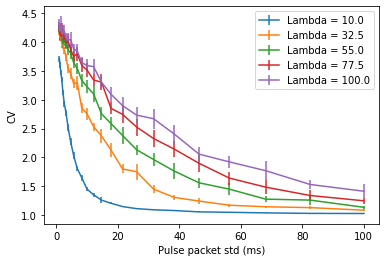

In [3]:
# This cell runs Fig. 1B

def cv_GPM(sigma,lam):
    nest.ResetKernel()
    nest.set_verbosity('M_FATAL')

    nest.rng_seed = np.random.randint(5000,10000)

    gauss_pulse_ex = nest.Create('pulsepacket_generator')
    gauss_pulse_in = nest.Create('pulsepacket_generator')
    end_time = 5000.
    pulse_gen = np.random.exponential(lam,10000)
    times = np.cumsum(pulse_gen)
    times = np.array(times[times<=end_time+100.],dtype=float)
    param_pulse_dict_ex = {'start':0.,'stop': end_time,'sdev':sigma,'activity':10,'pulse_times':times}

    nest.SetStatus(gauss_pulse_ex,param_pulse_dict_ex)
    
    spike_recorder = nest.Create('spike_recorder')
    
    nest.Connect(gauss_pulse_ex,spike_recorder)

    nest.Simulate(end_time+50.)
    spike_times = nest.GetStatus(spike_recorder,'events')[0]['times']
    
    return np.std(np.diff(spike_times))/np.mean(np.diff(spike_times))

lams = np.linspace(10.,100.,5)
sigmas = np.logspace(0,2,25)
nreps = 30

CVmeans = np.zeros([5,25])
CVstd = np.zeros([5,25])

for ilm,lam in enumerate(lams):
    for isg,sigma in enumerate(sigmas):
        temp = []
        for x in range(nreps):
            temp.append(cv_GPM(sigma,lam))
        temp = np.array(temp)
        CVmeans[ilm,isg] = np.mean(temp)
        CVstd[ilm,isg] = np.std(temp)
        
for ix,x in enumerate(lams):
    plt.errorbar(sigmas,CVmeans[ix,:],1.96*CVstd[ix,:]/np.sqrt(nreps))
np.random.exponential(lam,10000)
legend_text = []    
for lam in lams:
    legend_text.append('Lambda = %.1f'%lam)
plt.xlabel('Pulse packet std (ms)')
plt.ylabel('CV')
plt.legend(legend_text)
#plt.savefig('cv_examples.jpg',dpi=400) #uncomment to save figure
plt.show()

/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10


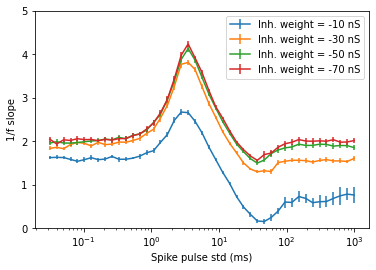

In [4]:
# this cell makes Fig. 1D

from fooof import FOOOF
import scipy.signal as signal

N_test = 45
sigmas = np.logspace(-1.5,3,N_test)
in_weights = np.array([-10.,-30.,-50.,-70.])
exponents = np.zeros([N_test,len(in_weights)])
exponents_err = np.zeros([N_test,len(in_weights)])

Nreps = 30

for idx_sig,sigma in enumerate(sigmas):
    for idx_w,in_weight in enumerate(in_weights):
        temp = []
        for i in range(Nreps):
            nest.ResetKernel()
            nest.set_verbosity('M_FATAL')

            nest.rng_seed = np.random.randint(5000,10000)

            gauss_pulse_ex = nest.Create('pulsepacket_generator')
            gauss_pulse_in = nest.Create('pulsepacket_generator')
            end_time = 5000.
            pulse_gen = np.random.exponential(50.,10000)
            times = np.cumsum(pulse_gen)
            times = np.array(times[times<=end_time+100.],dtype=float)
            param_pulse_dict_ex = {'start':0.,'stop': end_time,'sdev':sigma,'activity':10,'pulse_times':times}
            param_pulse_dict_in = {'start':0.,'stop': end_time,'sdev':sigma,'activity':20,'pulse_times':times}

            nest.SetStatus(gauss_pulse_ex,param_pulse_dict_ex)
            nest.SetStatus(gauss_pulse_in,param_pulse_dict_in)

            recorder = nest.Create('multimeter', {'record_from': ['V_m', 'g_ex','g_in']})
            neuron = nest.Create('hh_cond_beta_gap_traub',{'E_in':-80.,'C_m':150.,'tau_rise_ex':0.1,'tau_rise_in':0.5,'tau_decay_ex':2.,'tau_decay_in':10.})

            nest.Connect(gauss_pulse_ex,neuron,syn_spec={'weight':5.})
            nest.Connect(gauss_pulse_in,neuron,syn_spec={'weight':in_weight})
            nest.Connect(recorder,neuron)
            
            nest.Simulate(end_time+50.)

            sig_test = nest.GetStatus(recorder,'events')[0]['g_ex']*(0.0-nest.GetStatus(recorder,'events')[0]['V_m']) + nest.GetStatus(recorder,'events')[0]['g_in']*(-85.0-nest.GetStatus(recorder,'events')[0]['V_m'])
            fm = FOOOF(max_n_peaks=0,aperiodic_mode='knee',verbose=False)
            ff,psig = signal.welch(signal.detrend(sig_test[nest.GetStatus(recorder,'events')[0]['times']>500.]),fs=1000,nperseg=400,noverlap=300,scaling='spectrum')
            freq_range = [4,100]    
            repo = fm.fit(ff,psig,freq_range)
            
            temp.append(fm.aperiodic_params_[2])
        
        exponents[idx_sig,idx_w] = np.mean(np.array(temp))
        exponents_err[idx_sig,idx_w] = np.std(np.array(temp))

for i in range(len(in_weights)):
    plt.errorbar(sigmas,exponents[:,i],1.96*exponents_err[:,i]/np.sqrt(Nreps))
plt.xscale('log')
plt.xlabel('Spike pulse std (ms)')
plt.ylabel('1/f slope')
legend_text = []
for x in in_weights:
    legend_text.append('Inh. weight = %.0f nS'%x)
plt.legend(legend_text)
plt.ylim([0.,5.])

#plt.savefig('1fslope_pulsestd_more.jpg',dpi=400)
plt.show()

/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10
/usr/local/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning:invalid value encountered in log10


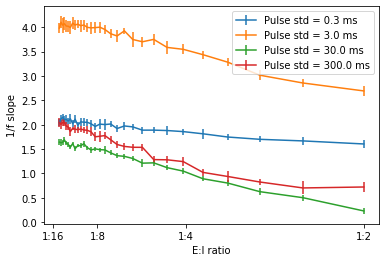

In [5]:
# this cell makes Fig. 1E

N_test = 4
sigmas = np.array([0.3,3.,30.,300.])#np.logspace(-1.5,3,N_test)
in_weights = np.linspace(-10.,-70,30)#np.array([-10.,-30.,-50.,-70.])
exponents = np.zeros([N_test,len(in_weights)])
exponents_err = np.zeros([N_test,len(in_weights)])

Nreps = 15

for idx_sig,sigma in enumerate(sigmas):
    for idx_w,in_weight in enumerate(in_weights):
        temp = []
        for i in range(Nreps):
            nest.ResetKernel()
            nest.set_verbosity('M_FATAL')

            nest.rng_seed = np.random.randint(5000,10000)

            gauss_pulse_ex = nest.Create('pulsepacket_generator')
            gauss_pulse_in = nest.Create('pulsepacket_generator')
            end_time = 5000.
            pulse_gen = np.random.exponential(50.,10000)
            times = np.cumsum(pulse_gen)
            times = np.array(times[times<=end_time+100.],dtype=float)
            param_pulse_dict_ex = {'start':0.,'stop': end_time,'sdev':sigma,'activity':10,'pulse_times':times}
            param_pulse_dict_in = {'start':0.,'stop': end_time,'sdev':sigma,'activity':20,'pulse_times':times}

            nest.SetStatus(gauss_pulse_ex,param_pulse_dict_ex)
            nest.SetStatus(gauss_pulse_in,param_pulse_dict_in)

            recorder = nest.Create('multimeter', {'record_from': ['V_m', 'g_ex','g_in']})
            neuron = nest.Create('hh_cond_beta_gap_traub',{'E_in':-80.,'C_m':150.,'tau_rise_ex':0.1,'tau_rise_in':0.5,'tau_decay_ex':2.,'tau_decay_in':10.})

            nest.Connect(gauss_pulse_ex,neuron,syn_spec={'weight':5.})
            nest.Connect(gauss_pulse_in,neuron,syn_spec={'weight':in_weight})
            nest.Connect(recorder,neuron)
            
            nest.Simulate(end_time+50.)

            sig_test = nest.GetStatus(recorder,'events')[0]['g_ex']*(0.0-nest.GetStatus(recorder,'events')[0]['V_m']) + nest.GetStatus(recorder,'events')[0]['g_in']*(-85.0-nest.GetStatus(recorder,'events')[0]['V_m'])
            fm = FOOOF(max_n_peaks=0,aperiodic_mode='knee',verbose=False)
            ff,psig = signal.welch(signal.detrend(sig_test[nest.GetStatus(recorder,'events')[0]['times']>500.]),fs=1000,nperseg=400,noverlap=300,scaling='spectrum')
            freq_range = [4,100]    
            repo = fm.fit(ff,psig,freq_range)
            
            temp.append(fm.aperiodic_params_[2])
        
        exponents[idx_sig,idx_w] = np.mean(np.array(temp))
        exponents_err[idx_sig,idx_w] = np.std(np.array(temp))

for i in range(len(sigmas)):
    plt.errorbar(-5/in_weights,exponents[i],1.96*exponents_err[i]/np.sqrt(Nreps))       

plt.xticks([1/2,1/4,1/8,1/16],labels=['1:2','1:4','1:8','1:16'])
plt.xlabel('E:I ratio')
plt.ylabel('1/f slope')

legend_text = []
for x in sigmas:
    legend_text.append('Pulse std = %.1f ms'%x)
plt.legend(legend_text)
#plt.savefig('ratio_plot.jpg',dpi=400)
plt.show()

## Code for Fig. 2 

See the comments at the top of each of the cells to see which panel of Fig. 2 the cell makes. 

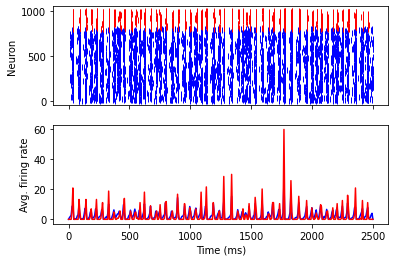

3.0179551979341723
0.2848354232050513


In [6]:
#this code makes cells 2AB if you modify the like below indicated by the #<-------

nest.ResetKernel()
nest.rng_seed = np.random.randint(10000,60000)
ndict = {"I_e": nest.random.normal(mean=100.0,std=15.)}
ndictI = {"I_e": nest.random.normal(mean=140.0,std=15.)}
popE = nest.Create('iaf_cond_alpha',800,ndict)
popI = nest.Create('iaf_cond_alpha',200,ndictI)
conn_dict_ex = {"rule": "fixed_indegree", "indegree": 50}

nest.Connect(popE,popE,conn_dict_ex,syn_spec={"weight":6.0})#<------- MODIFY THIS TO CHANGE W_EE AS IN PAPER
nest.Connect(popE,popI,conn_dict_ex,syn_spec={"weight":10.0})
nest.Connect(popI,popE,conn_dict_ex,syn_spec={"weight":-3.0})
nest.Connect(popI,popI,conn_dict_ex,syn_spec={"weight":-3.0})

popE.set({'V_m':nest.random.normal(mean=-62.,std=1.5)})
popI.set({'V_m':nest.random.normal(mean=-62.,std=1.5)})

sr = nest.Create('spike_recorder')
stim = nest.Create('poisson_generator',800)
nest.SetStatus(stim,{"rate":140.0})
nest.Connect(popE,sr)
nest.Connect(popI,sr)
nest.Connect(stim,popE,"one_to_one",syn_spec={"weight":14.0})

#proxy neuron
recorder = nest.Create('multimeter', {'record_from': ['V_m', 'g_ex','g_in']})
neuron = nest.Create('hh_cond_beta_gap_traub',{'E_in':-80.,'C_m':150.,'tau_rise_ex':0.1,'tau_rise_in':0.5,'tau_decay_ex':2.,'tau_decay_in':10.})
conn_dict_ex_proxy = {"rule": "fixed_indegree", "indegree":400}
conn_dict_in_proxy = {"rule": "fixed_indegree", "indegree": 100}
#conn_dict_ex_proxy = {"rule": "all_to_all"}
#conn_dict_in_proxy = {"rule": "all_to_all"}
nest.Connect(popE,neuron,conn_dict_ex_proxy,syn_spec={'weight':5.})
nest.Connect(popI,neuron,conn_dict_in_proxy,syn_spec={'weight':-20.})
nest.Connect(recorder,neuron)

t_sim = 2500.0
nest.Simulate(t_sim)
sig_test = nest.GetStatus(recorder,'events')[0]['g_ex']*(0.0-nest.GetStatus(recorder,'events')[0]['V_m']) + nest.GetStatus(recorder,'events')[0]['g_in']*(-85.0-nest.GetStatus(recorder,'events')[0]['V_m'])
fm = FOOOF(max_n_peaks=3,peak_threshold=3.,min_peak_height=0.5,aperiodic_mode='knee',verbose=False)
ff,psig = signal.welch(signal.detrend(sig_test[nest.GetStatus(recorder,'events')[0]['times']>500.]),fs=1000,nperseg=400,noverlap=300,scaling='spectrum')
freq_range = [4,100]    
repo = fm.fit(ff,psig,freq_range)
expo = fm.aperiodic_params_[2]

N_bins = 350
N_E_neurons = 800
N_I_neurons = 200
binned_times = np.linspace(0,t_sim,N_bins)
binned_rate_E = np.zeros(N_bins)
binned_rate_I = np.zeros(N_bins)
for idx,time in enumerate(binned_times[:-1]):
    delta_t =  (binned_times[idx+1] - binned_times[idx])/1000.
    binned_rate_E[idx]=(sum((sr.events["times"][sr.events["senders"]<801] > binned_times[idx]) & (sr.events["times"][sr.events["senders"]<801] < binned_times[idx+1]))/delta_t)/N_E_neurons
    binned_rate_I[idx]=(sum((sr.events["times"][sr.events["senders"]>=801] > binned_times[idx]) & (sr.events["times"][sr.events["senders"]>=801] < binned_times[idx+1]))/delta_t)/N_I_neurons

fig,ax = plt.subplots(2,1,sharex=True)

ax[0].plot(sr.events['times'][sr.events['senders']<801],sr.events['senders'][sr.events['senders']<801],'|b')
ax[0].plot(sr.events['times'][sr.events['senders']>=801],sr.events['senders'][sr.events['senders']>=801],'|r')
ax[0].set(ylabel='Neuron')
ax[1].plot(binned_times,binned_rate_E,'b')
ax[1].plot(binned_times,binned_rate_I,'r')
ax[1].set(xlabel='Time (ms)',ylabel='Avg. firing rate')
#plt.savefig('raster_sigma.jpg',dpi=400)
plt.show()

print(expo)

spike_fmt = []
for nrn in sr.events['senders']:
    spike_fmt.append(spk.SpikeTrain(sr.events['times'][sr.events['senders']==nrn],edges=(0.,t_sim),is_sorted=False))
sync_index = spk.spike_sync(spike_fmt,indices=range(0,1000))

print(sync_index)

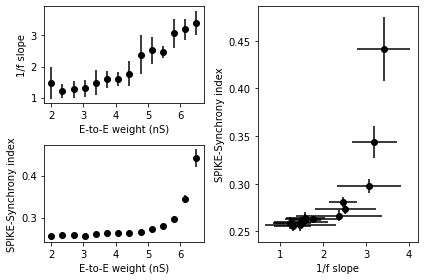

In [7]:
# This cell returns panels 2C-E

def repeated_network_stim(gEE,Nreps):
    expos = np.zeros([len(gEE),Nreps])
    sync_indexs = np.zeros([len(gEE),Nreps])
    
    for idx_gee,gEE_val in enumerate(gEE):
        for Nrep_idx in range(0,Nreps):
            nest.ResetKernel()
            nest.rng_seed = np.random.randint(10000,60000)
            ndict = {"I_e": nest.random.normal(mean=100.0,std=15.)}
            ndictI = {"I_e": nest.random.normal(mean=140.0,std=15.)}
            popE = nest.Create('iaf_cond_alpha',800,ndict)
            popI = nest.Create('iaf_cond_alpha',200,ndictI)
            conn_dict_ex = {"rule": "fixed_indegree", "indegree": 50}

            nest.Connect(popE,popE,conn_dict_ex,syn_spec={"weight":gEE_val})
            nest.Connect(popE,popI,conn_dict_ex,syn_spec={"weight":10.0})
            nest.Connect(popI,popE,conn_dict_ex,syn_spec={"weight":-3.0})
            nest.Connect(popI,popI,conn_dict_ex,syn_spec={"weight":-3.0})

            popE.set({'V_m':nest.random.normal(mean=-62.,std=1.5)})
            popI.set({'V_m':nest.random.normal(mean=-62.,std=1.5)})

            sr = nest.Create('spike_recorder')
            stim = nest.Create('poisson_generator',800)
            nest.SetStatus(stim,{"rate":140.0})
            nest.Connect(popE,sr)
            nest.Connect(popI,sr)
            nest.Connect(stim,popE,"one_to_one",syn_spec={"weight":14.0})

            #proxy neuron
            recorder = nest.Create('multimeter', {'record_from': ['V_m', 'g_ex','g_in']})
            neuron = nest.Create('hh_cond_beta_gap_traub',{'E_in':-80.,'C_m':150.,'tau_rise_ex':0.1,'tau_rise_in':0.5,'tau_decay_ex':2.,'tau_decay_in':10.})
            conn_dict_ex_proxy = {"rule": "fixed_indegree", "indegree":400}
            conn_dict_in_proxy = {"rule": "fixed_indegree", "indegree": 100}
            #conn_dict_ex_proxy = {"rule": "all_to_all"}
            #conn_dict_in_proxy = {"rule": "all_to_all"}
            nest.Connect(popE,neuron,conn_dict_ex_proxy,syn_spec={'weight':5.})
            nest.Connect(popI,neuron,conn_dict_in_proxy,syn_spec={'weight':-20.})
            nest.Connect(recorder,neuron)

            t_sim = 2500.0
            nest.Simulate(t_sim)
            sig_test = nest.GetStatus(recorder,'events')[0]['g_ex']*(0.0-nest.GetStatus(recorder,'events')[0]['V_m']) + nest.GetStatus(recorder,'events')[0]['g_in']*(-85.0-nest.GetStatus(recorder,'events')[0]['V_m'])
            fm = FOOOF(max_n_peaks=3,peak_threshold=3.,min_peak_height=0.5,aperiodic_mode='knee',verbose=False)
            ff,psig = signal.welch(signal.detrend(sig_test[nest.GetStatus(recorder,'events')[0]['times']>500.]),fs=1000,nperseg=400,noverlap=300,scaling='spectrum')
            freq_range = [4,100]    
            repo = fm.fit(ff,psig,freq_range)
            expo = fm.aperiodic_params_[2]
            spike_fmt = []
            for nrn in sr.events['senders']:
                spike_fmt.append(spk.SpikeTrain(sr.events['times'][sr.events['senders']==nrn],edges=(0.,t_sim),is_sorted=False))
            sync_index = spk.spike_sync(spike_fmt,indices=range(0,1000))

            expos[idx_gee,Nrep_idx] = expo
            sync_indexs[idx_gee,Nrep_idx] = sync_index
    
    return expos,sync_indexs

Ngee = 14
Nrep_gee = 10
testexpos, testsyncs = repeated_network_stim(np.linspace(2.,6.5,num=Ngee),Nrep_gee)


axs0=plt.subplot(221)
axs1=plt.subplot(223,sharex=axs0)
axs2=plt.subplot(122)

axs0.errorbar(np.linspace(2.,6.5,num=Ngee),np.mean(testexpos,1),1.96*np.std(testexpos,1)/np.sqrt(Nrep_gee),fmt='ok')
axs0.set_xlabel('E-to-E weight (nS)')
axs0.set_ylabel('1/f slope')

axs1.errorbar(np.linspace(2.,6.5,num=Ngee),np.mean(testsyncs,1),1.96*np.std(testsyncs,1)/np.sqrt(Nrep_gee),fmt='ok')
axs1.set_xlabel('E-to-E weight (nS)')
axs1.set_ylabel('SPIKE-Synchrony index')

axs2.errorbar(np.mean(testexpos,1),np.mean(testsyncs,1),yerr=np.std(testsyncs,1),xerr=np.std(testexpos,1),fmt='ok')
axs2.set_ylabel('SPIKE-Synchrony index')
axs2.set_xlabel('1/f slope')

plt.tight_layout()
#plt.savefig('SPIKE_sync_1f_sigma.jpg',dpi=400)
plt.show()